##Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/My Drive/neuro140fp"
!ls


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/neuro140fp
 am_dataset			    mistakes		       NotoSerif.ttf
'Amharic Character Dataset 1.rar'   mistakes_denseNet.csv      orig1_dataset-2
 ethiopic_CM.ipynb		    mistakes_generator.ipynb   supported_chars.csv
 ethiopic.ipynb			    mistakes_list.csv	       training_results
 ethiopic_newDS.ipynb		    models_path		       visualize_results.ipynb
 ethiopic_newds.py		    newDomain_results


In [ ]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
import pickle
from torchvision import transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random

class Ethiopic(Dataset):
    def __init__(self, data_dir, csv_path, transform=None):
        self.data_dir = data_dir
        self.image_filenames = os.listdir(data_dir)
        self.transform = transform
        self.char_to_id_mapping = self._create_char_to_id_mapping(csv_path)

    def _create_char_to_id_mapping(self, csv_path):
        df = pd.read_csv(csv_path)
        char_to_id_mapping = {char: i for i, char in enumerate(df['Character'].unique())}
        return char_to_id_mapping

    def __getitem__(self, idx):
        filename = self.image_filenames[idx]
        image = Image.open(os.path.join(self.data_dir, filename))
        if self.transform:
          image = self.transform(image)

        file_id = int(filename.split('.')[0][:3])
        label_part = filename.split('.')[0][3:]

        label = file_id - 1

        return image, label

    def __len__(self):
        return len(self.image_filenames)



##Verifying Image and label mapping
here I randomly selected 10 images and labels from the dataset to verify for accurate mapping.

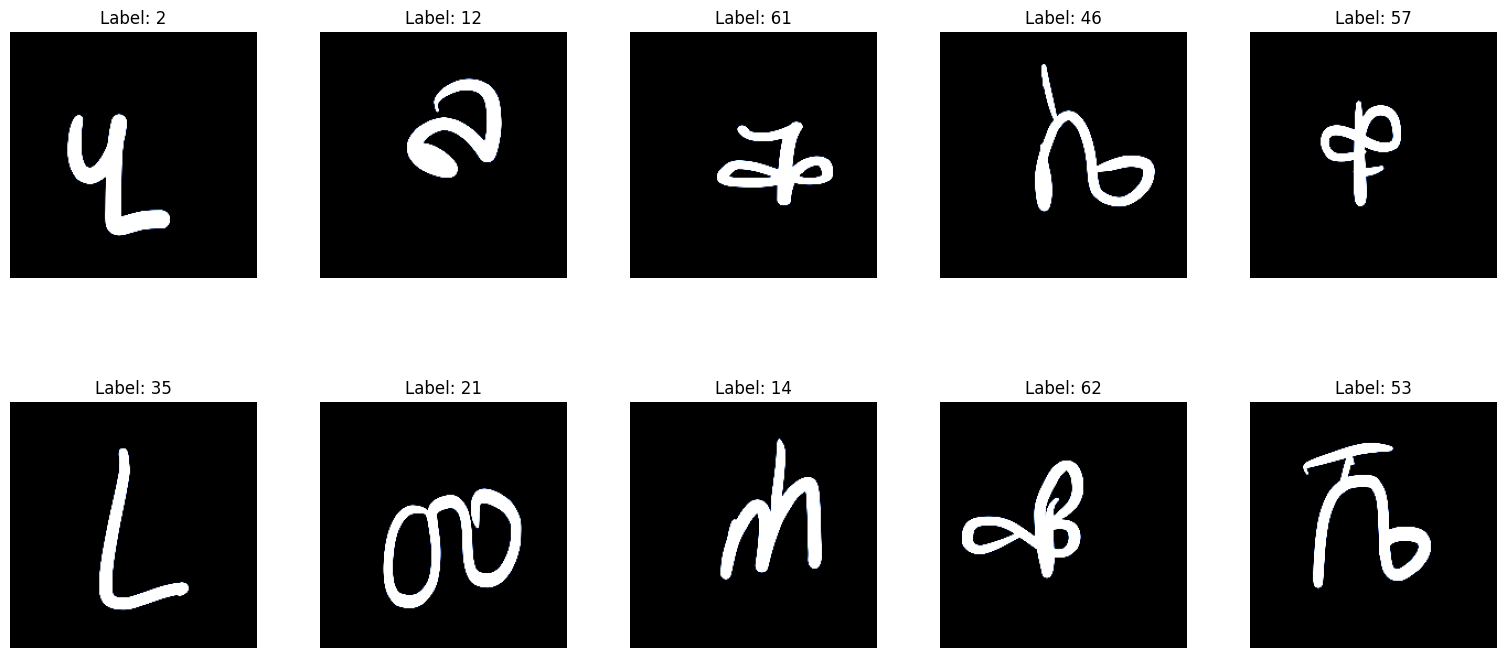

In [ ]:
# train_transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Lambda(lambda x: x.repeat(3, 1, 1))
# ])

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resizing the image
    transforms.RandomHorizontalFlip(),  # Randomly flipping the image horizontally
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to RGB by repeating channels

    transforms.RandomRotation(10),  # Random rotation
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Randomly change brightness, contrast, and other factors
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ImageNet stats
    # transforms.Lambda(lambda x: x.repeat(3, 1, 1))  # Ensuring 3 channel for models expecting RGB inputs
])
# test_transform = transforms.Compose([
#     transforms.Resize((224, 224)),

#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize using ImageNet stats

# ])
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to RGB by repeating channels
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Same as train dataset
])


train_dataset = Ethiopic(data_dir ="/content/drive/My Drive/neuro140fp/am_dataset",csv_path = "/content/drive/My Drive/neuro140fp/supported_chars.csv", transform = train_transform)
test_dataset = Ethiopic(data_dir ="/content/drive/My Drive/neuro140fp/orig1_dataset-2",csv_path = "/content/drive/My Drive/neuro140fp/supported_chars.csv", transform = test_transform)
indices = random.sample(range(len(test_dataset)), 10)

# Set up the plot
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for i, idx in enumerate(indices):
    image, label = test_dataset[idx]

    image_np = image.numpy().transpose((1, 2, 0))
    if image_np.shape[2] == 1:
        image_np = np.squeeze(image_np, axis=2)
    axs[i].imshow(image_np, cmap='gray')
    axs[i].set_title(f'Label: {label}')
    axs[i].axis('off')

plt.show()

##Do train and test split

In [ ]:
from torch.utils.data import DataLoader, random_split
# total_size = len(dataset)
# train_size = int(0.8 * total_size)
# val_size = total_size - train_size


# train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

##Train and validate

In [ ]:
# torch.cuda.empty_cache()

import torch
import pandas as pd
from torchvision import models
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from fastprogress import progress_bar


model_dict = {
    # 'AlexNet': models.alexnet(),
    'ResNet': models.resnet18()
    # 'DenseNet': models.densenet121(),
    # 'VGG_net': models.vgg16_bn(pretrained = False)
}

results = {
    'model_name': [],
    # 'epoch': [],
    'train_accuracy': [],
    'test_accuracy': [],
    'train_loss': [],
    'test_loss': [],
}

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

for model_name, model in model_dict.items():
    for epoch in range(20):
      model_path = f'/content/drive/My Drive/neuro140fp/models_path/{model_name}_epoch_{epoch}.pth'
      # model.load_state_dict(torch.load(model_path))
      model.to(device)
      criterion = nn.CrossEntropyLoss()
      optimizer = optim.Adam(model.parameters(), lr=0.001)

      model.train()
      train_correct = 0
      train_total = 0
      train_loss_accum = 0

      for inputs, labels in progress_bar(train_dataloader):
          inputs, labels = inputs.to(device), labels.to(device)
          optimizer.zero_grad()
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          train_loss_accum += loss.item() * inputs.size(0)  # Aggregate the loss
          _, predicted = torch.max(outputs.data, 1)
          train_total += labels.size(0)
          train_correct += (predicted == labels).sum().item()

      train_accuracy = train_correct / train_total
      train_loss = train_loss_accum / train_total
      print(f'Model: {model_name}, Train Acc: {train_accuracy:.4f}, Train Loss: {train_loss:.4f}')


    val_correct = 0
    val_total = 0
    val_loss_accum = 0
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss_accum += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_accuracy = val_correct / val_total
    val_loss = val_loss_accum / val_total

    print(f'Model: {model_name}, Val Acc: {val_accuracy:.4f}, Val Loss: {val_loss:.4f}')

        # Save results
    results['model_name'].append(model_name)
    # results['epoch'].append(epoch)
    results['train_accuracy'].append(train_accuracy)
    results['test_accuracy'].append(val_accuracy)
    results['train_loss'].append(train_loss)
    results['test_loss'].append(val_loss)
    models_folder = "models_path"

      # if not os.path.exists(models_folder):
      #   os.makedirs(models_folder)

    # torch.save(model.state_dict(), os.path.join(models_folder, f'{model_name}_epoch_{epoch}.pth'))

# Convert results to DataFrame and save to CSV
    results_df = pd.DataFrame(results)
    results_df.to_csv(f'{model_name}_with_aug.csv', index=False)





cuda


KeyboardInterrupt: 

In [ ]:
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader


loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)
mean = 0.
std = 0.
for images, _ in loader:
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
mean /= len(loader.dataset)
std /= len(loader.dataset)
print("mean", mean)
print("std", std)




/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


mean tensor([-1.0156, -0.9088, -0.6825])
std tensor([0.8346, 0.8532, 0.8494])


In [ ]:
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),

    transforms.ToTensor(),
    transforms.Normalize(mean=[-1.0156, -0.9088, -0.6825], std=[0.8346, 0.8532, 0.8494]),

])

train_dataset = Ethiopic(data_dir ="/content/drive/My Drive/neuro140fp/am_dataset",csv_path = "/content/drive/My Drive/neuro140fp/supported_chars.csv", transform = train_transform)
test_dataset = Ethiopic(data_dir ="/content/drive/My Drive/neuro140fp/orig1_dataset-2",csv_path = "/content/drive/My Drive/neuro140fp/supported_chars.csv", transform = test_transform)
val_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

torch.cuda.empty_cache()

import torch
import pandas as pd
from torchvision import models
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from fastprogress import progress_bar

# Assuming you have defined train_loader, val_loader, and num_epochs
# Assuming dataset and loaders setup

model_dict = {
    'AlexNet': models.alexnet(),
    'ResNet': models.resnet18(),
    'DenseNet': models.densenet121(),
    'VGG_net': models.vgg16_bn(pretrained = False)
}

results = {
    'model_name': [],
    'epoch': [],
    # 'train_accuracy': [],
    'val_accuracy': [],
    # 'train_loss': [],
    'val_loss': [],
}

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

for model_name, model in model_dict.items():
    for epoch in range(20):
      model_path = f'/content/drive/My Drive/neuro140fp/models_path/{model_name}_epoch_{epoch}.pth'
      model.load_state_dict(torch.load(model_path))
      model.to(device)
      model.eval()
      criterion = nn.CrossEntropyLoss()


    # for epoch in range(20):
    #     model.train()
    #     train_correct = 0
    #     train_total = 0
    #     train_loss_accum = 0

    #     for inputs, labels in progress_bar(train_dataloader):
    #         inputs, labels = inputs.to(device), labels.to(device)
    #         optimizer.zero_grad()
    #         outputs = model(inputs)
    #         loss = criterion(outputs, labels)
    #         loss.backward()
    #         optimizer.step()

    #         train_loss_accum += loss.item() * inputs.size(0)  # Aggregate the loss
    #         _, predicted = torch.max(outputs.data, 1)
    #         train_total += labels.size(0)
    #         train_correct += (predicted == labels).sum().item()

    #     train_accuracy = train_correct / train_total
    #     train_loss = train_loss_accum / train_total


      val_correct = 0
      val_total = 0
      val_loss_accum = 0
      with torch.no_grad():
          for inputs, labels in val_dataloader:
              inputs, labels = inputs.to(device), labels.to(device)
              outputs = model(inputs)
              loss = criterion(outputs, labels)

              val_loss_accum += loss.item() * inputs.size(0)
              _, predicted = torch.max(outputs.data, 1)
              val_total += labels.size(0)
              val_correct += (predicted == labels).sum().item()

      val_accuracy = val_correct / val_total
      val_loss = val_loss_accum / val_total

      print(f'Epoch {epoch} - Model: {model_name}, Val Acc: {val_accuracy:.4f}, Val Loss: {val_loss:.4f}')

        # Save results
      results['model_name'].append(model_name)
      results['epoch'].append(epoch)
      # results['train_accuracy'].append(train_accuracy)
      results['val_accuracy'].append(val_accuracy)
      # results['train_loss'].append(train_loss)
      results['val_loss'].append(val_loss)
      models_folder = "models_path"

      # if not os.path.exists(models_folder):
      #   os.makedirs(models_folder)

    # torch.save(model.state_dict(), os.path.join(models_folder, f'{model_name}_epoch_{epoch}.pth'))

# Convert results to DataFrame and save to CSV
    results_df = pd.DataFrame(results)
    results_df.to_csv(f'{model_name}_validation_results_normalized_forDS.csv', index=False)




/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


cuda
Epoch 0 - Model: AlexNet, Val Acc: 0.0000, Val Loss: 4.7618
Epoch 1 - Model: AlexNet, Val Acc: 0.0196, Val Loss: 4.7115
Epoch 2 - Model: AlexNet, Val Acc: 0.0196, Val Loss: 5.2330
Epoch 3 - Model: AlexNet, Val Acc: 0.0196, Val Loss: 6.1135
Epoch 4 - Model: AlexNet, Val Acc: 0.0392, Val Loss: 18.2996
Epoch 5 - Model: AlexNet, Val Acc: 0.0196, Val Loss: 26.8291
Epoch 6 - Model: AlexNet, Val Acc: 0.0392, Val Loss: 22.8863
Epoch 7 - Model: AlexNet, Val Acc: 0.0196, Val Loss: 26.0473
Epoch 8 - Model: AlexNet, Val Acc: 0.0392, Val Loss: 23.3223
Epoch 9 - Model: AlexNet, Val Acc: 0.0392, Val Loss: 14.3732
Epoch 10 - Model: AlexNet, Val Acc: 0.0196, Val Loss: 25.6258
Epoch 11 - Model: AlexNet, Val Acc: 0.0196, Val Loss: 30.2810
Epoch 12 - Model: AlexNet, Val Acc: 0.0196, Val Loss: 19.5467
Epoch 13 - Model: AlexNet, Val Acc: 0.0196, Val Loss: 21.3419
Epoch 14 - Model: AlexNet, Val Acc: 0.0196, Val Loss: 24.2607
Epoch 15 - Model: AlexNet, Val Acc: 0.0196, Val Loss: 21.6320
Epoch 16 - Model: